# Tracker tutorial
This repository is an implementation of a paper "On Tracking The Partition Function" by G. Desjardins et al. They developed a method to track partition function of RBM. Even though it is generally impossible to calculate partition function of large RBM, they make it feasible by using Kalman filter. The method track partition function of large RBM by modifying the estimate of partition function a little by little following the learning of RBM. I implemented the partition function tracker using Kalman filter described in the paper as a "tracker" module. 
Here I will go through basic usage of the module.

Before we begin this tutorial, you need to compile the tracker module first. See README.md for compilation.

## 1. Simple usage on toy model
First I show basic usage of tracker module by measuring the partition function of RBM with constantly changing parameter. This will illustrate how to use a class "tracker.PyTracker" and functions "tracker.py_lpf_ais" and "tracker.py_lpf_det".

We must import related libraries first.

In [28]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time
import tracker
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Then define initial parameter of RBM. Parameter of RBM consists of visible unit bias "b", hidden unit bias "c" and connection weight matrix "w". Define these variables as in usual RBM initialization.

In [2]:
n_vis = 100
n_hid = 10
b = np.zeros(n_vis)
c = np.zeros(n_hid)
scale = np.sqrt(1.0 / (n_vis + n_hid))
w = np.random.uniform(low=-scale, high=scale, size=(n_vis, n_hid))

Before we begin tracking partition function, we must instantiate PyTracker class. Instantiation take 4 argument, "n_beta" for division of temperature, "n_batch" for batch of each temperature and "n_vis", "n_hid". You find detailed meanings of these parameters in the paper. Then we need to set parameter of the target RBM.

In [3]:
n_beta = 100
n_batch = 30
tkr = tracker.PyTracker(n_beta, n_batch, n_vis, n_hid)
tkr.set_params(b, c, w)

Since tracking uses Kalman filter, we need first estimate of partition function. First estimate can be generated by either "init_mu_p" method implementing parallel tempering or "init_ais" method implementing ais for each temperature. Since calculation is light for "init_mu_p" than "init_ais" we use "init_mu_p" here.

In [4]:
tkr.init_mu_p()

Basic work flow of tracking partition function is to update internal estimate of partition function by

tkr.track(new_b, new_c, new_w)

which updates estimate of partition function and internal RBM parameter of PyTracker instance. Then get updated estimate by

lpf, std_lpf = tkr.get_estimates()

which generates log partition function estimate and its standard deviation.

Then we begin track partition function. We increase parameter "w" for 5 epoch and decrease parameter "w" for 5 epoch and see the difference between the method, AIS and Deterministic calculation. AIS is calculated by the function "tracker.py_lpf_det" and deterministic calculation is executed by function "tracker.py_lpf_det".

In [5]:
n_epoch = 10
till_down = 5

mean_trk_list = list()
std_trk_list = list()
mean_ais_list = list()
std_ais_list = list()
mean_det_list = list()
for i in range(n_epoch):
    time.sleep(1.0)
    
    if i < till_down:
        w += 1e-4
    else:
        w -= 1e-4
    
    tkr.track(b, c, w)
    mean_trk, std_trk = tkr.get_estimates()
    mean_ais, std_ais = tracker.py_lpf_ais(b, c, w)
    mean_det = tracker.py_lpf_det(b, c, w)
    
    mean_trk_list.append(mean_trk)
    std_trk_list.append(std_trk)
    mean_ais_list.append(mean_ais)
    std_ais_list.append(std_ais)
    mean_det_list.append(mean_det)
    
    print("Finish", i, "th epoch", "mean_det", mean_det)
    print("mean_trk", mean_trk, "std_trk", std_trk)
    print("mean_ais", mean_ais, "std_ais", std_ais)

Finish 0 th epoch mean_det 112.76684619293844
mean_trk 112.85631262023972 std_trk 0.1396383198635881
mean_ais 112.76428383821676 std_ais 0.01871347656338445
Finish 1 th epoch mean_det 112.80857781318701
mean_trk 112.87026457017578 std_trk 0.11957855301855837
mean_ais 112.79314915089476 std_ais 0.03538286326332398
Finish 2 th epoch mean_det 112.85032959903378
mean_trk 112.91214957432702 std_trk 0.10685642010140252
mean_ais 112.87292673691634 std_ais 0.016515596417598522
Finish 3 th epoch mean_det 112.8921015837425
mean_trk 112.94808312300219 std_trk 0.09954858182143722
mean_ais 112.86651041648794 std_ais 0.02093161002869813
Finish 4 th epoch mean_det 112.9338938006446
mean_trk 112.98424446818916 std_trk 0.09477111391154405
mean_ais 112.93482325616462 std_ais 0.026028193170209588
Finish 5 th epoch mean_det 112.8921015837425
mean_trk 112.94530445233926 std_trk 0.09078424374666148
mean_ais 112.88736454637072 std_ais 0.013473433327220499
Finish 6 th epoch mean_det 112.85032959903378
mean_tr

First plot tracking estimate with deterministic calculation.

Text(0,0.5,'lpf')

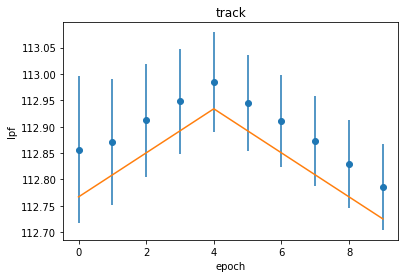

In [6]:
plt.errorbar(np.arange(n_epoch), mean_trk_list,
            yerr=std_trk_list, fmt="o")
plt.plot(mean_det_list)
plt.title("track")
plt.xlabel("epoch")
plt.ylabel("lpf")

Text(0,0.5,'lpf')

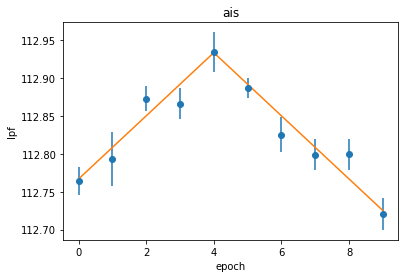

In [7]:
plt.errorbar(np.arange(n_epoch), mean_ais_list,
             yerr=std_ais_list, fmt="o")
plt.plot(mean_det_list)
plt.title("ais")
plt.xlabel("epoch")
plt.ylabel("lpf")

## 2. Track partition function of RBM
We then apply tracker to RBM training. We will track partition function of RBM while training RBM with MNIST dataset. Since RBM itself is a huge structure that we cannot calculate exact partition function easily, following simulations compare partition function estimate by AIS and tracker. 

First import rbm utility functions. "load_mnist" is a function to load mnist dataset. "calc_update_stoc" is for calculating negative gradient of RBM. "calc_xentropy" is to calculate cross entropy loss.

In [36]:
from rbm_utils import load_mnist, calc_update_stoc, calc_xentropy

Before applying tracker to RBM training, we need to fetch MNIST dataset to train RBM. Fetch mnist.pkl.gz with wget. If you don't have wget on your machine, please get wget first.

In [37]:
if not os.path.exists("data/mnist.pkl.gz"):
    os.system("wget -P ./data/ http://deeplearning.net/data/mnist/mnist.pkl.gz ")
imgs, n_vis = load_mnist("data/mnist.pkl.gz")

Here we have 70000 images of digits in size of 28 * 28 = 784 

In [38]:
print(imgs.shape)

(70000, 784)


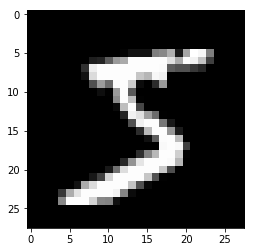

In [39]:
plt.imshow(imgs[0].reshape(28,28))
plt.gray()

Next we initialize parameters of RBM. RBM has three kinds of parameters. "b" for visible unit bias, "c" for hidden unit bias and "w" for connection weight matrix. Here we take number of hidden units to be 100.

In [40]:
n_hid = 100
b = np.zeros(n_vis)
c = np.zeros(n_hid)
scale = np.sqrt(1.0 / (n_vis + n_hid))
w = np.random.normal(scale=scale, size=(n_vis, n_hid))

Then we also initialize tracker with parameters of RBM.

In [41]:
n_beta = 10
n_batch = 10
tkr = tracker.PyTracker(n_beta, n_batch, n_vis, n_hid)
tkr.set_params(b, c, w)
tkr.init_mu_p()

Finally we begin batched training of RBM and partition function tracking. This will take a few minuites.

In [42]:
max_epoch = 101
train_batch = 20
learning_rate = 0.001

ais_epoch_list = list()
m_ais_list = list()
std_ais_list = list()
trk_epoch_list = list()
m_trk_list = list()
std_trk_list = list()
for epoch in range(max_epoch):
    time.sleep(1.0)
    
    # Choose train batch for this epoch
    img_idxs = np.random.choice(len(imgs), train_batch)
    batch = imgs[img_idxs]
    
    # Learn RBM
    ub, uc, uw = calc_update_stoc(batch, b, c, w)
    b += learning_rate * ub
    c += learning_rate * uc
    w += learning_rate * uw
    
    # Track
    tkr.track(b, c, w)
    m_trk, std_trk = tkr.get_estimates()
    trk_epoch_list.append(epoch)
    m_trk_list.append(m_trk)
    std_trk_list.append(std_trk)
    
    # AIS
    if epoch % 10 == 0:
        m_ais, std_ais = tracker.py_lpf_ais(b, c, w)
        ais_epoch_list.append(epoch)
        m_ais_list.append(m_ais)
        std_ais_list.append(std_ais)
    
    if epoch % 10 == 0:
        xent = calc_xentropy(batch, b, c, w)
        print("Epoch", epoch, "xent", xent)
        print("----", "m_trk", m_trk, "std_trk", std_trk)
        print("----", "m_ais", m_ais, "std_ais", std_ais)

Epoch 0 xent 542.273982128
---- m_trk 618.2467222573304 std_trk 0.4092325134052979
---- m_ais 618.4265938451679 std_ais 0.0066233635712991575
Epoch 10 xent 512.289664531
---- m_trk 586.6572032285968 std_trk 0.40038855162791714
---- m_ais 587.2069743566741 std_ais 0.005714104756723807
Epoch 20 xent 485.760129953
---- m_trk 567.4613504284788 std_trk 0.47040431493697976
---- m_ais 568.1278818453736 std_ais 0.004133855707006442
Epoch 30 xent 466.118563674
---- m_trk 555.7205806318236 std_trk 0.45172308332170824
---- m_ais 556.0433442149458 std_ais 0.006473683313737337
Epoch 40 xent 450.480427641
---- m_trk 547.5005372077616 std_trk 0.42832669840457527
---- m_ais 548.4592859061837 std_ais 0.004867082393186511
Epoch 50 xent 434.142414866
---- m_trk 542.900931124666 std_trk 0.4315140023731735
---- m_ais 543.4479146613041 std_ais 0.009893471898800662
Epoch 60 xent 419.866153086
---- m_trk 539.4067278411078 std_trk 0.4278908105003984
---- m_ais 539.9671934605601 std_ais 0.00834981182853661
Epoc

Text(0,0.5,'lpf')

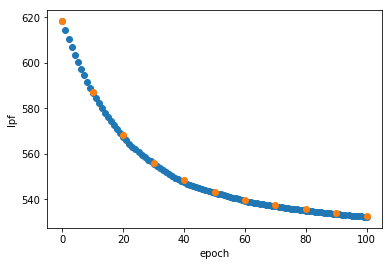

In [44]:
plt.errorbar(trk_epoch_list, m_trk_list,
             yerr=std_trk_list, fmt="o")
plt.errorbar(ais_epoch_list, m_ais_list,
             yerr=std_ais_list, fmt="o")
plt.xlabel("epoch")
plt.ylabel("lpf")

We can see that estimates of tracker is same to estimates of AIS. 